### Accuracy assessment

In [32]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = "data/accuracy_assesment"
errors_by_distance_cm = {}

for distance in range(1, 11):
    file_path = os.path.join(data_dir, f"data_{distance}m.txt")
    
    with open(file_path, 'r') as file:
        raw_data = file.readlines()
    
    raw_data = [x for x in raw_data if x[0] == '{']
    parsed_data = [ast.literal_eval(x) for x in raw_data]
    
    df = pd.DataFrame(parsed_data)
    df = df[df['s'] == 0]
    
    true_distance_cm = distance * 100
    
    df['error'] = df['D'] - true_distance_cm
    
    df = df[np.abs(df['error']) < 25]
    
    df = df.iloc[300:1000].copy()

    errors_by_distance_cm[distance] = df['error'].values

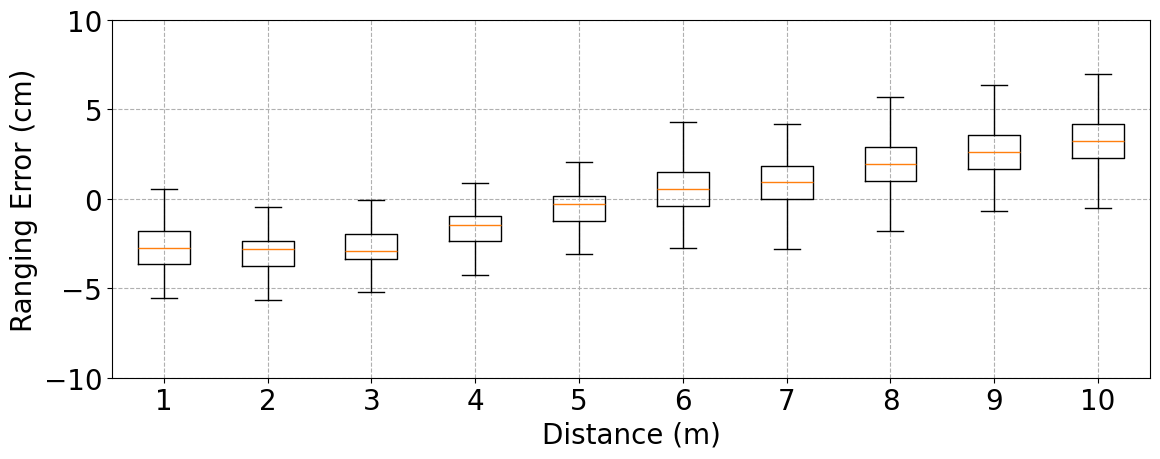

In [34]:
error_df_cm = pd.DataFrame({f"{k}": pd.Series(v, dtype='float') for k, v in errors_by_distance_cm.items()})

font = {
    'size': 20
}
plt.rc('font', **font)

plt.figure(figsize=(12, 5))
plt.boxplot(error_df_cm.values, tick_labels=error_df_cm.columns, showfliers=False)
plt.xlabel("Distance (m)")
plt.ylabel("Ranging Error (cm)")
plt.xticks()
plt.yticks()
plt.ylim(-10, 10)
plt.grid(True, linestyle='--')

plt.tight_layout()
plt.savefig("ranging_accuracy_box.pdf", bbox_inches='tight')

### Synchronization assessment

In [35]:
path = "data/slot_corr_vis_saved.txt"

with open(path, 'r') as file:
    data = file.readlines()

data = [x for x in data if x[0] == '{']
data = [ast.literal_eval(x) for x in data]

df = pd.DataFrame(data)

Processing anchor b4ca, row 0
Processing anchor b4ca, row 1
Processing anchor b4ca, row 2
Processing anchor b4ca, row 3
Processing anchor b538, row 0
Processing anchor b538, row 1
Processing anchor b538, row 2
Processing anchor b538, row 3
Processing anchor b557, row 0
Processing anchor b557, row 1
Processing anchor b557, row 2
Processing anchor b557, row 3
Processing anchor b52e, row 0
Processing anchor b52e, row 1
Processing anchor b52e, row 2
Processing anchor b52e, row 3


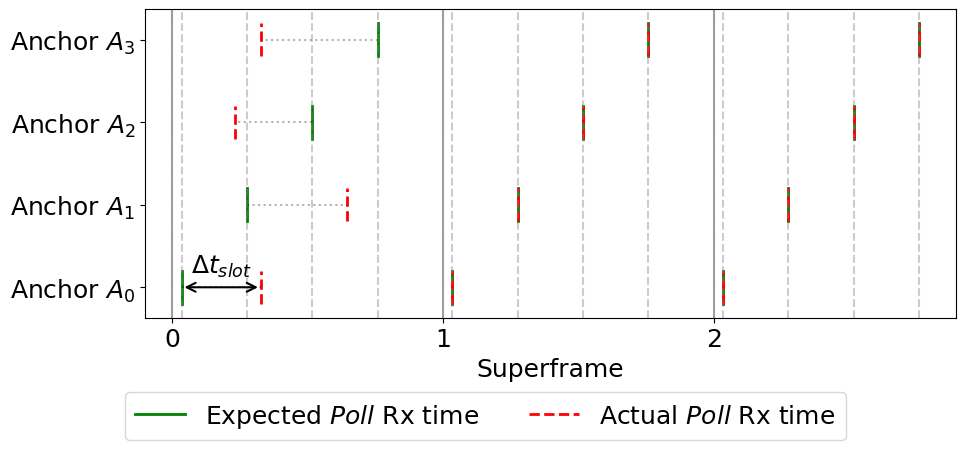

In [37]:
font = {'size': 18}
plt.rc('font', **font)

SLOT_PERIOD = 3500
GUARD_TIME = 500

anchors_list = ["b4ca", "b538", "b557", "b52e"]
slot_times = [GUARD_TIME + i * SLOT_PERIOD for i in range(len(anchors_list))]

SF_PERIOD = SLOT_PERIOD * len(anchors_list) + GUARD_TIME

fig, ax = plt.subplots(figsize=(10, 5))

yticks = []
yticklabels = []

legend = True

for i, anchor in enumerate(anchors_list):
    anchor_df = df[df['a'] == anchor]
    anchor_idx = anchors_list.index(anchor)
    y_base = i * 1
    yticks.append(y_base)
    yticklabels.append(f'Anchor $A_{i}$')

    j = 0
    for _, row in anchor_df.iterrows():
        print(f"Processing anchor {anchor}, row {j}")
        if j > 2:
            break

        slot_correction = row['sc']
        
        x_exp = j * SF_PERIOD + slot_times[anchor_idx]
        x_act = x_exp + slot_correction
        
        ax.plot([x_exp, x_exp], [y_base - 0.2, y_base + 0.2], '-', label='Expected $\it{Poll}$ Rx time' if legend else "", linewidth=2, color='green')
        ax.plot([x_act, x_act], [y_base - 0.2, y_base + 0.2], '--', label='Actual $\it{Poll}$ Rx time' if legend else "", linewidth=2, color='red')
        ax.plot([x_exp, x_act], [y_base, y_base], 'k:', alpha=0.3)
        
        if legend:
            ax.annotate('', xy=(x_exp, y_base), xytext=(x_act, y_base),
                        arrowprops=dict(arrowstyle='<->', lw=1.5), fontsize=16, ha='center', va='bottom')
            ax.text((x_exp + x_act) / 2, y_base + 0.1, f'$\Delta t_{{slot}}$', fontsize=18, ha='center', va='bottom')
        j += 1
        legend = False

sf_ticks = [n * SF_PERIOD for n in range(3)]
sf_labels = [f'{n}' for n in range(3)]
for x in sf_ticks:
    ax.axvline(x=x, linestyle='-', color='gray', alpha=0.75)

slot_labels = [f'Slot {i}' for i in range(len(anchors_list))]
for i in range(len(sf_labels)):
    for j, x in enumerate(slot_times):
        x_sf = x + i * SF_PERIOD
        ax.axvline(x=x_sf, linestyle='--', color='gray', alpha=0.4)
        
ax.set_xticks(sf_ticks)
ax.set_xticklabels(sf_labels)
ax.set_xlabel(f'Superframe')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.grid(True, axis='x', linestyle='--', alpha=0.3)

ax.legend(loc='upper center', bbox_to_anchor=(0.42, -0.2), ncol=2, fontsize=18)

plt.tight_layout()
plt.savefig('sync_visualize.pdf', bbox_inches='tight')